# Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [11]:
def multiply_tool(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply_tool])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [12]:
from langchain_core.messages import HumanMessage

result = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [13]:
result.content

''

In [14]:
result.tool_calls

[{'name': 'multiply_tool',
  'args': {'a': 2, 'b': 3},
  'id': 'call_FzJLyobMfAaLs9zMhreTeQPN',
  'type': 'tool_call'}]

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

## Graph with tool calling llm

Now, lets use `MessagesState` with a graph.

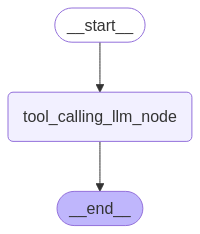

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply_tool (call_r8ouwlz2dUSOEgqX3cPoR0cC)
 Call ID: call_r8ouwlz2dUSOEgqX3cPoR0cC
  Args:
    a: 2
    b: 3


### Let's add a tool node to execute the llm tool request:

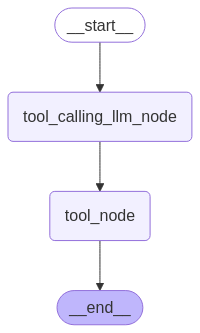

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode([multiply_tool]))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", "tool_node")
builder.add_edge("tool_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply_tool (call_bmTeh0fo6LlUXcU0XrhmxXwY)
 Call ID: call_bmTeh0fo6LlUXcU0XrhmxXwY
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply_tool

6


In [37]:
# Q: what is the initial question didn't have a request for tool call?
# For example, it was "What is the capital of Cyprus?"

## Ok, let's add more tools!

In [38]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, 
# and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, 
# see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

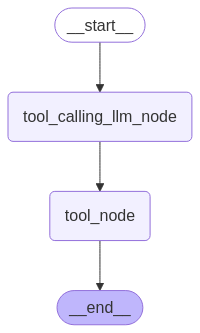

In [39]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", "tool_node")
builder.add_edge("tool_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Uf7XmkuoYpsZm5sJqQIsGLnx)
 Call ID: call_Uf7XmkuoYpsZm5sJqQIsGLnx
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [41]:
messages = graph.invoke({"messages": HumanMessage(content="Devide 6 by 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Devide 6 by 2
================================== Ai Message ==================================
Tool Calls:
  divide (call_V1HNetVuCMA0pbBoO9bgkUaS)
 Call ID: call_V1HNetVuCMA0pbBoO9bgkUaS
  Args:
    a: 6
    b: 2
================================= Tool Message =================================
Name: divide

3.0
